# Fundamental Analysis

### Loading Data

In [1]:
import pandas as pd
from vnstock_ezchart import *
from vnstock import Vnstock
import warnings
warnings.filterwarnings("ignore")
# Instantiate 
stock = Vnstock().stock(symbol='REE', source='VCI')
company = Vnstock().stock(symbol="REE",source="TCBS").company

# Load
CashFlow = stock.finance.cash_flow(period='year')
BalanceSheet = stock.finance.balance_sheet(period='year', lang='en', dropna=True)
IncomeStatement = stock.finance.income_statement(period='year', lang='en', dropna=True)
Ratio = stock.finance.ratio(period='year', lang='en', dropna=True)
dividend_schedule = company.dividends()


/Users/tamle/Projects/Jupyter/.venv/lib/python3.10/site-packages/vnai/scope/profile.py:742: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Phiên bản Vnstock 3.2.6 đã có mặt, vui lòng cập nhật với câu lệnh : `pip install vnstock --upgrade`.
Lịch sử phiên bản: https://vnstocks.com/docs/tai-lieu/lich-su-phien-ban
Phiên bản hiện tại 3.2.5

2025-06-14 12:28:04 - vnstock.common.data.data_explorer - INFO - TCBS không cung cấp thông tin danh sách. Dữ liệu tự động trả về từ VCI.


## Calculation

In [2]:
# Levered Free Cash Flow (accounts for debt repayments/receipts)
CashFlow['Levered Free Cash Flow'] = (
    CashFlow['Net cash inflows/outflows from operating activities'] 
    - CashFlow['Purchase of fixed assets']
    + CashFlow['Proceeds from disposal of fixed assets']
    - (CashFlow['Repayment of borrowings'] - CashFlow['Proceeds from borrowings'])
)

dividend_coverage_ratio = CashFlow['Levered Free Cash Flow'] / CashFlow['Dividends paid'].abs()

In [3]:
#Create a new column for Dividend Coverage calculation and add that column back to the original CashFlow dataframe
CashFlow['Dividend Coverage Ratio'] = CashFlow['Levered Free Cash Flow'] / CashFlow['Dividends paid'].abs()
# Select the 2 columns in CashFlow dataframe and store it in a new variable which create a new df for dividend coverage ratio
dividend_coverage_ratio = CashFlow[["yearReport", "Dividend Coverage Ratio"]]

In [4]:
#Convert pandas series to dataframe 
dividend_coverage_ratio = pd.DataFrame(dividend_coverage_ratio)
FCF =CashFlow[['yearReport','Levered Free Cash Flow']]

### Effective tax rate 

In [7]:
def calculate_effective_tax_rate(IncomeStatement, CashFlow):
   """
   Calculate the effective tax rate using Income Statement and Cash Flow data.
   
   Effective Tax Rate = Tax Expense / Profit Before Tax
   
   Parameters:
   -----------
   IncomeStatement : pandas DataFrame
       Income Statement data with columns: ticker, yearReport, etc.
   CashFlow : pandas DataFrame
       Cash Flow Statement data with columns: ticker, yearReport, 'Net Profit/Loss before tax', 'Business Income Tax paid'
       
   Returns:
   --------
   pandas DataFrame
       DataFrame with effective tax rate calculations
   """
   # Merge the necessary data from both financial statements
   tax_data_df = pd.merge(
       IncomeStatement[['ticker', 'yearReport', 'Profit before tax']],
       CashFlow[['ticker', 'yearReport', 'Business Income Tax paid', 'Net Profit/Loss before tax']],
       on=['ticker', 'yearReport'],
       how='inner'
   )
   
   # Use Profit before tax from Income Statement if available, otherwise use from Cash Flow
   tax_data_df['Profit Before Tax (Bn. VND)'] = tax_data_df['Profit before tax'].fillna(tax_data_df['Net Profit/Loss before tax'])
   
   # Calculate effective tax rate with absolute value of tax paid (since it appears as negative in cash flow)
   tax_data_df['Tax Paid (Bn. VND)'] = tax_data_df['Business Income Tax paid'].abs()
   
   # Calculate effective tax rate
   tax_data_df['Effective Tax Rate'] = tax_data_df['Tax Paid (Bn. VND)'] / tax_data_df['Profit Before Tax (Bn. VND)']
   
   # Handle edge cases (negative profits, zero profits, etc.)
   tax_data_df['Effective Tax Rate'] = tax_data_df['Effective Tax Rate'].clip(0, 1)  # Cap between 0 and 1
   
   # Select relevant columns
   tax_data_df = tax_data_df[['ticker', 'yearReport', 'Profit Before Tax (Bn. VND)', 
                              'Tax Paid (Bn. VND)', 'Effective Tax Rate']]
   
   return tax_data_df

### Dupont Analysis

In [5]:
import pandas as pd
import numpy as np

def create_dupont_analysis(IncomeStatement, BalanceSheet, CashFlow):
    """
    Create a 3-factor DuPont analysis based on the three financial statements.
    
    DuPont Analysis: ROE = Net Profit Margin × Asset Turnover × Financial Leverage
    
    Where:
    - Net Profit Margin = Net Income / Revenue
    - Asset Turnover = Revenue / Average Total Assets
    - Financial Leverage = Average Total Assets / Average Shareholders' Equity
    
    Returns:
    --------
    pandas DataFrame
        DataFrame with DuPont analysis results
    """
    # Step 1: Combine necessary data from all three statements
    # Start with Income Statement data for revenue and net income
    income_data = IncomeStatement[['ticker', 'yearReport', 'Revenue (Bn. VND)', 'Attribute to parent company (Bn. VND)']].copy()
    
    # Rename for clarity
    income_data = income_data.rename(columns={'Attribute to parent company (Bn. VND)': 'Net Income (Bn. VND)'})
    
    # Step 2: Add Balance Sheet data for assets and equity
    balance_data = BalanceSheet[['ticker', 'yearReport', 'TOTAL ASSETS (Bn. VND)', "OWNER'S EQUITY(Bn.VND)"]].copy()
    
    # Merge the dataframes
    dupont_df = pd.merge(income_data, balance_data, on=['ticker', 'yearReport'], how='inner')
    
    # Step 3: Group by ticker to calculate year-over-year values and averages
    # Sort by ticker and year
    dupont_df = dupont_df.sort_values(['ticker', 'yearReport'])
    
    # Calculate average total assets and equity for each year (current + previous year) / 2
    # First create shifted columns for previous year's values
    dupont_df['Prev_Assets'] = dupont_df.groupby('ticker')['TOTAL ASSETS (Bn. VND)'].shift(1)
    dupont_df['Prev_Equity'] = dupont_df.groupby('ticker')["OWNER'S EQUITY(Bn.VND)"].shift(1)
    
    # Calculate averages
    dupont_df['Average Total Assets (Bn. VND)'] = (dupont_df['TOTAL ASSETS (Bn. VND)'] + dupont_df['Prev_Assets']) / 2
    dupont_df['Average Equity (Bn. VND)'] = (dupont_df["OWNER'S EQUITY(Bn.VND)"] + dupont_df['Prev_Equity']) / 2
    
    # For the first year of each ticker, we don't have previous year data, so use current year
    dupont_df['Average Total Assets (Bn. VND)'] = dupont_df['Average Total Assets (Bn. VND)'].fillna(
        dupont_df['TOTAL ASSETS (Bn. VND)'])
    dupont_df['Average Equity (Bn. VND)'] = dupont_df['Average Equity (Bn. VND)'].fillna(
        dupont_df["OWNER'S EQUITY(Bn.VND)"])
    
    # Step 4: Calculate the 3 DuPont components
    # Net Profit Margin = Net Income / Revenue
    dupont_df['Net Profit Margin'] = dupont_df['Net Income (Bn. VND)'] / dupont_df['Revenue (Bn. VND)']
    
    # Asset Turnover = Revenue / Average Total Assets
    dupont_df['Asset Turnover'] = dupont_df['Revenue (Bn. VND)'] / dupont_df['Average Total Assets (Bn. VND)']
    
    # Financial Leverage = Average Total Assets / Average Equity
    dupont_df['Financial Leverage'] = dupont_df['Average Total Assets (Bn. VND)'] / dupont_df['Average Equity (Bn. VND)']
    
    # Step 5: Calculate ROE using DuPont formula
    dupont_df['ROE (DuPont)'] = dupont_df['Net Profit Margin'] * dupont_df['Asset Turnover'] * dupont_df['Financial Leverage']
    
    # Step 6: Calculate ROE directly for validation
    dupont_df['ROE (Direct)'] = dupont_df['Net Income (Bn. VND)'] / dupont_df['Average Equity (Bn. VND)']
    
    # Step 7: Clean up the DataFrame and select relevant columns
    dupont_analysis = dupont_df[[
        'ticker', 'yearReport', 
        'Net Income (Bn. VND)', 'Revenue (Bn. VND)',
        'Average Total Assets (Bn. VND)', 'Average Equity (Bn. VND)',
        'Net Profit Margin', 'Asset Turnover', 'Financial Leverage',
        'ROE (DuPont)', 'ROE (Direct)'
    ]]
    
    # Convert ratios to percentages for better readability
    dupont_analysis['Net Profit Margin'] = dupont_analysis['Net Profit Margin'] * 100
    dupont_analysis['ROE (DuPont)'] = dupont_analysis['ROE (DuPont)'] * 100
    dupont_analysis['ROE (Direct)'] = dupont_analysis['ROE (Direct)'] * 100
    
    # Round values for better display
    dupont_analysis = dupont_analysis.round({
        'Net Profit Margin': 2,
        'Asset Turnover': 2,
        'Financial Leverage': 2,
        'ROE (DuPont)': 2,
        'ROE (Direct)': 2
    })
    
    return dupont_analysis

# Usage:
dupont_analysis = create_dupont_analysis(IncomeStatement, BalanceSheet, CashFlow)
dupont_analysis

,ticker,yearReport,Net Income (Bn. VND),Revenue (Bn. VND),Average Total Assets (Bn. VND),Average Equity (Bn. VND),Net Profit Margin,Asset Turnover,Financial Leverage,ROE (DuPont),ROE (Direct)
11,REE,2013,975819282949,2414569501626,6.954450e+12,5.196623e+12,40.41,0.35,1.34,18.78,18.78
10,REE,2014,1061971178941,2630675383788,7.678818e+12,5.767437e+12,40.37,0.34,1.33,18.41,18.41
9,REE,2015,853082411270,2645193904607,9.006055e+12,6.510635e+12,32.25,0.29,1.38,13.10,13.10
8,REE,2016,1093237014487,3663193468551,1.050278e+13,7.202081e+12,29.84,0.35,1.46,15.18,15.18
7,REE,2017,1377087391977,4999235436523,1.284565e+13,8.207209e+12,27.55,0.39,1.57,16.78,16.78
6,REE,2018,1783971852557,5104605853407,1.489717e+13,9.310823e+12,34.95,0.34,1.60,19.16,19.16
5,REE,2019,1638893522530,4896700913533,1.756121e+13,1.051502e+13,33.47,0.28,1.67,15.59,15.59
4,REE,2020,1628076208584,5644088890450,2.007661e+13,1.165716e+13,28.85,0.28,1.72,13.97,13.97
3,REE,2021,1855079628131,5815207697974,2.617873e+13,1.428526e+13,31.90,0.22,1.83,12.99,12.99
2,REE,2022,2692516590418,9377949892489,3.287078e+13,1.778078e+13,28.71,0.29,1.85,15.14,15.14


### Capital Employed

In [8]:
def calculate_capital_employed(BalanceSheet):
   """
   Calculate Capital Employed for each company and year in the Balance Sheet data.
   
   Capital Employed = Long-term Debt + Current Portion of Debt + Shareholder's Equity
   
   Parameters:
   -----------
   BalanceSheet : pandas DataFrame
       Balance Sheet data with columns: ticker, yearReport, 
       'Long-term borrowings (Bn. VND)', 'Short-term borrowings (Bn. VND)',
       "OWNER'S EQUITY(Bn.VND)"
       
   Returns:
   --------
   pandas DataFrame
       DataFrame with Capital Employed calculations
   """
   # Create a copy to avoid modifying the original dataframe
   balance_sheet_copy = BalanceSheet.copy()
   
   # Fill NA values with 0 to avoid calculation issues
   balance_sheet_copy['Long-term borrowings (Bn. VND)'] = balance_sheet_copy['Long-term borrowings (Bn. VND)'].fillna(0)
   balance_sheet_copy['Short-term borrowings (Bn. VND)'] = balance_sheet_copy['Short-term borrowings (Bn. VND)'].fillna(0)
   balance_sheet_copy["OWNER'S EQUITY(Bn.VND)"] = balance_sheet_copy["OWNER'S EQUITY(Bn.VND)"].fillna(0)
   
   # Calculate Capital Employed based on the specified formula
   balance_sheet_copy['Capital Employed (Bn. VND)'] = (
       balance_sheet_copy['Long-term borrowings (Bn. VND)'] + 
       balance_sheet_copy['Short-term borrowings (Bn. VND)'] + 
       balance_sheet_copy["OWNER'S EQUITY(Bn.VND)"]
   )
   
   # Select relevant columns for the output
   capital_employed_df = balance_sheet_copy[['ticker', 'yearReport', 
                                            'Long-term borrowings (Bn. VND)', 
                                            'Short-term borrowings (Bn. VND)',
                                            "OWNER'S EQUITY(Bn.VND)",
                                            'Capital Employed (Bn. VND)']]
   
   return capital_employed_df

# Example usage (commented out):
capital_employed_df = calculate_capital_employed(BalanceSheet)

### NOPAT

In [ ]:
def calculate_nopat_with_effective_tax(IncomeStatement, tax_table):
   """
   Calculate NOPAT (Net Operating Profit After Tax) and EBIT (Earnings Before Interest and Taxes)
   using effective tax rates from the tax_table.
   
   NOPAT = EBIT * (1 - Effective Tax Rate)
   
   Parameters:
   -----------
   IncomeStatement : pandas DataFrame
       Income Statement data with 'Operating Profit/Loss' column
   tax_table : pandas DataFrame
       DataFrame with effective tax rates, containing columns:
       'ticker', 'yearReport', 'Effective Tax Rate'
       
   Returns:
   --------
   pandas DataFrame
       DataFrame with NOPAT and EBIT calculations
   """
   # Create a copy to avoid modifying the original dataframe
   income_statement_copy = IncomeStatement.copy()
   
   # Rename Operating Profit/Loss to EBIT for clarity
   income_statement_copy['EBIT (Bn. VND)'] = income_statement_copy['Operating Profit/Loss']
   
   # Merge with tax_table to get effective tax rates
   nopat_calculation_df = pd.merge(
       income_statement_copy[['ticker', 'yearReport', 'EBIT (Bn. VND)']],
       tax_table[['ticker', 'yearReport', 'Effective Tax Rate']],
       on=['ticker', 'yearReport'],
       how='left'
   )
   
   # Handle cases where effective tax rate is not available
   # Use default tax rate of 20% as fallback
   nopat_calculation_df['Effective Tax Rate'] = nopat_calculation_df['Effective Tax Rate'].fillna(0.20)
   
   # Calculate NOPAT using effective tax rates
   nopat_calculation_df['NOPAT (Bn. VND)'] = nopat_calculation_df['EBIT (Bn. VND)'] * (1 - nopat_calculation_df['Effective Tax Rate'])
   
   # Select relevant columns for the output
   profit_df = nopat_calculation_df[['ticker', 'yearReport', 'EBIT (Bn. VND)', 
                                    'Effective Tax Rate', 'NOPAT (Bn. VND)']]
   
   return profit_df

In [ ]:
profit_comparison_table = calculate_nopat_with_effective_tax(IncomeStatement, tax_table)
#profit_comparison_table = profit_comparison_table.set_index('yearReport')
profit_comparison_table = profit_comparison_table.sort_values(by='yearReport', ascending=True)
profit_comparison_table

### Degree of Financial Leverage

In [6]:
def calculate_degree_of_financial_leverage(IncomeStatement):
    """
    Calculate Degree of Financial Leverage using percentage changes in Net Income and EBIT.
    
    DFL = % Change in Net Income / % Change in EBIT
    
    Parameters:
    -----------
    IncomeStatement : pandas DataFrame
        Income Statement data with columns including 'Operating Profit/Loss' and 'Attribute to parent company (Bn. VND)'
    
    Returns:
    --------
    pandas DataFrame
        DataFrame with DFL calculations
    """
    # Create a copy to avoid modifying the original dataframe
    financial_leverage_data = IncomeStatement.copy()
    
    # Rename for clarity
    financial_leverage_data = financial_leverage_data.rename(columns={
        'Operating Profit/Loss': 'EBIT (Bn. VND)',
        'Attribute to parent company (Bn. VND)': 'Net Income (Bn. VND)'
    })
    
    # Sort by ticker and year
    financial_leverage_data = financial_leverage_data.sort_values(['ticker', 'yearReport'])
    
    # Calculate year-over-year percentage changes for each ticker
    financial_leverage_data['EBIT % Change'] = financial_leverage_data.groupby('ticker')['EBIT (Bn. VND)'].pct_change() * 100
    financial_leverage_data['Net Income % Change'] = financial_leverage_data.groupby('ticker')['Net Income (Bn. VND)'].pct_change() * 100
    
    # Calculate DFL
    financial_leverage_data['DFL'] = financial_leverage_data['Net Income % Change'] / financial_leverage_data['EBIT % Change']
    
    # Handle infinite or NaN values (when EBIT % Change is near zero)
    financial_leverage_data['DFL'] = financial_leverage_data['DFL'].replace([np.inf, -np.inf], np.nan)
    
    # Select relevant columns
    dfl_results = financial_leverage_data[['ticker', 'yearReport', 
                                         'EBIT (Bn. VND)', 'Net Income (Bn. VND)', 
                                         'EBIT % Change', 'Net Income % Change', 
                                         'DFL']]
    
    return dfl_results

calculate_degree_of_financial_leverage(IncomeStatement)

,ticker,yearReport,EBIT (Bn. VND),Net Income (Bn. VND),EBIT % Change,Net Income % Change,DFL
11,REE,2013,653760115839,975819282949,NaN,NaN,NaN
10,REE,2014,1209735776640,1061971178941,85.042762,8.828673,0.103815
9,REE,2015,1038784287138,853082411270,-14.131308,-19.669909,1.391938
8,REE,2016,1368547876590,1093237014487,31.745146,28.151395,0.886794
7,REE,2017,1711671841121,1377087391977,25.072120,25.964212,1.035581
6,REE,2018,2105657869033,1783971852557,23.017615,29.546742,1.283658
5,REE,2019,1909681072333,1638893522530,-9.307153,-8.132322,0.873771
4,REE,2020,1901472471574,1628076208584,-0.429841,-0.660038,1.535537
3,REE,2021,2387222069978,1855079628131,25.545971,13.943046,0.545802
2,REE,2022,3985852232731,2692516590418,66.966127,45.142912,0.674116


## WACC

In [12]:
from vnstock import Quote

# Initialize Quote object for VN-Index
quote = Quote(symbol='VNINDEX', source='VCI')
start_date = '2024-01-01'
end_date = '2025-06-14'
interval = '1D'

# Get historical data
vnindex_data = quote.history(
    start=start_date,
    end=end_date,
    interval=interval
)

print(vnindex_data.head())

        time     open     high      low    close      volume
0 2024-01-02  1138.01  1139.71  1128.69  1131.72   842255467
1 2024-01-03  1131.97  1144.17  1128.32  1144.17   719932658
2 2024-01-04  1145.49  1160.08  1144.32  1150.72  1181354559
3 2024-01-05  1151.43  1155.84  1149.08  1154.68   803268328
4 2024-01-08  1157.54  1162.56  1155.48  1160.19   905408420


In [13]:
stock = Vnstock().stock(symbol='REE', source='VCI')

# Get recent historical data (last 30 days)
stock_price = stock.quote.history(
    start=start_date, 
    end=end_date,
    interval=interval
)

### Book value cost of debt

In [14]:
# Step 1: Capital Structure from Balance Sheet
# Get debt components
short_term_debt = BalanceSheet['Short-term borrowings (Bn. VND)']
long_term_debt = BalanceSheet['Long-term borrowings (Bn. VND)']
total_debt = short_term_debt + long_term_debt

# Get equity
total_equity = BalanceSheet["OWNER'S EQUITY(Bn.VND)"]
total_capital = total_debt + total_equity

# Calculate weights
weight_of_debt = total_debt / total_capital
weight_of_equity = total_equity / total_capital

# Step 2: Cost of Debt using book value approach
interest_expense = CashFlow['Interest Expense']  # or 'Interest paid' if more appropriate
average_debt = (short_term_debt + long_term_debt)  # Ideally would use average of beginning/ending periods

# Handle division by zero properly for Series
pre_tax_cost_of_debt = interest_expense.div(average_debt).fillna(0)

# Tax rate (using standard Vietnamese corporate tax rate)
statutory_tax_rate = 0.11
after_tax_cost_of_debt = pre_tax_cost_of_debt * (1 - statutory_tax_rate)

# Step 3: Cost of Equity - include both ROE and CAPM methods
# Method 1: Using ROE from ratio data
roe = Ratio[('Chỉ tiêu khả năng sinh lợi', 'ROE (%)')] / 100  # Convert percentage to decimal

# Method 2: CAPM approach using financial leverage
risk_free_rate = 0.03  # Vietnamese government bond yield (adjust as needed)
financial_leverage = Ratio[('Chỉ tiêu thanh khoản', 'Financial Leverage')]
# Calculate mean of financial leverage (handle potential issues)
leverage_mean = financial_leverage.mean()
# Estimate beta using financial leverage
estimated_beta = 1.0 * financial_leverage / leverage_mean if leverage_mean != 0 else 1.0
market_risk_premium = 0.05  # Estimated risk premium for Vietnamese market

# Calculate cost of equity using CAPM
capm_cost_of_equity = risk_free_rate + (estimated_beta * market_risk_premium)

# Step 4: Calculate WACC with both methods
wacc_roe = (weight_of_debt * after_tax_cost_of_debt) + (weight_of_equity * roe)
wacc_capm = (weight_of_debt * after_tax_cost_of_debt) + (weight_of_equity * capm_cost_of_equity)

# Create a DataFrame with the results
result_df = pd.DataFrame({
    'ticker': BalanceSheet['ticker'],
    'yearReport': BalanceSheet['yearReport'],
    'weight_of_debt': weight_of_debt,
    'weight_of_equity': weight_of_equity,
    'pre_tax_cost_of_debt': pre_tax_cost_of_debt,
    'after_tax_cost_of_debt': after_tax_cost_of_debt,
    'cost_of_equity_roe': roe,
    'financial_leverage': financial_leverage,
    'estimated_beta': estimated_beta,
    'cost_of_equity_capm': capm_cost_of_equity,
    'wacc_roe': wacc_roe,
    'wacc_capm': wacc_capm
})

result_df

,ticker,yearReport,weight_of_debt,weight_of_equity,pre_tax_cost_of_debt,after_tax_cost_of_debt,cost_of_equity_roe,financial_leverage,estimated_beta,cost_of_equity_capm,wacc_roe,wacc_capm
0,REE,2024,0.316483,0.683517,0.071348,0.063500,0.001101,1.619358,1.009786,0.080489,0.020849,0.075112
1,REE,2023,0.340902,0.659098,0.087753,0.078100,0.001333,1.680891,1.048156,0.082408,0.027503,0.080939
2,REE,2022,0.372526,0.627474,0.077867,0.069301,0.001869,1.766044,1.101255,0.085063,0.026989,0.079191
3,REE,2021,0.422633,0.577367,0.056224,0.050039,0.001299,1.945668,1.213264,0.090663,0.021898,0.073494
4,REE,2020,0.314358,0.685642,0.075337,0.067050,0.001397,1.681081,1.048275,0.082414,0.022035,0.077584
5,REE,2019,0.336361,0.663639,0.073653,0.065551,0.001559,1.767551,1.102195,0.085110,0.023083,0.078531
6,REE,2018,0.242673,0.757327,0.071199,0.063367,0.001916,1.561149,0.973489,0.078674,0.016829,0.074960
7,REE,2017,0.255330,0.744670,0.035239,0.031363,0.001678,1.644336,1.025362,0.081268,0.009257,0.068526
8,REE,2016,0.162096,0.837904,0.040276,0.035845,0.001518,1.476030,0.920411,0.076021,0.007082,0.069508
9,REE,2015,0.129141,0.870859,0.074636,0.066426,0.001310,1.437812,0.896579,0.074829,0.009719,0.073744


In [17]:
# Step 1: Get book values from Balance Sheet
short_term_debt = BalanceSheet['Short-term borrowings (Bn. VND)']
long_term_debt = BalanceSheet['Long-term borrowings (Bn. VND)']
total_debt = short_term_debt + long_term_debt
book_equity = BalanceSheet["OWNER'S EQUITY(Bn.VND)"]

# Step 2: Get market values
# Market capitalization for equity
market_value_of_equity = Ratio[('Chỉ tiêu định giá', 'Market Capital (Bn. VND)')]  # Market capitalization

# Use book value of debt as a proxy for market value of debt
# (In practice, we'd prefer bond prices or yield-based valuation if available)
market_value_of_debt = total_debt

# Calculate total market capital and weights
total_market_capital = market_value_of_equity + market_value_of_debt
market_weight_of_debt = market_value_of_debt.div(total_market_capital).fillna(0)
market_weight_of_equity = market_value_of_equity.div(total_market_capital).fillna(0)

# Step 3: Market-based cost of debt
# Option 1: If you have specific bond yield data (example values)
# In reality, this would vary by company or be derived from external data sources
base_interest_rate = 0.04  # e.g., Vietnamese government bond rate
credit_spread = 0.03       # Credit spread based on company rating
company_bond_yield = base_interest_rate + credit_spread  # = 0.05 (5%)

# Option 2: Use credit rating to determine yield (if available)
# This would be a mapping from credit ratings to yields
# rating_to_yield = {'AAA': 0.035, 'AA': 0.04, 'A': 0.045, 'BBB': 0.05, 'BB': 0.06, 'B': 0.07}
# company_bond_yield = rating_to_yield.get(company_rating, 0.05)  # Default to 5% if rating unknown

# Use fixed rate for simplicity (you would replace this with company-specific data)
market_cost_of_debt = 0.07  # 7% bond yield

# Apply tax shield
statutory_tax_rate = 0.20  # Vietnamese corporate tax rate
after_tax_market_cost_of_debt = market_cost_of_debt * (1 - statutory_tax_rate)

# Step 4: Cost of Equity using CAPM
risk_free_rate = 0.03  # Vietnamese government bond yield

# Option 1: If you have beta data from external sources
# estimated_beta = external_beta_data  # This would be company-specific

# Option 2: Estimate beta using financial leverage
financial_leverage = Ratio[('Chỉ tiêu thanh khoản', 'Financial Leverage')]
leverage_mean = financial_leverage.mean()
estimated_beta = 1.0 * financial_leverage.div(leverage_mean).fillna(1.0)  # Default to 1.0 if issues

# Market risk premium
market_risk_premium = 0.05  # Estimated risk premium for Vietnamese market

# Calculate cost of equity using CAPM
cost_of_equity = risk_free_rate + (estimated_beta * market_risk_premium)

# Step 5: Calculate market-based WACC
wacc_market_based = (market_weight_of_debt * after_tax_market_cost_of_debt) + (market_weight_of_equity * cost_of_equity)

# Create a DataFrame with the results
result_df = pd.DataFrame({
    'ticker': BalanceSheet['ticker'],
    'yearReport': BalanceSheet['yearReport'],
    'market_cap': market_value_of_equity,
    'market_debt': market_value_of_debt,
    'market_weight_of_debt': market_weight_of_debt,
    'market_weight_of_equity': market_weight_of_equity,
    'market_cost_of_debt': after_tax_market_cost_of_debt,
    'beta': estimated_beta,
    'cost_of_equity': cost_of_equity,
    'wacc_market_based': wacc_market_based
})

wacc_market_based

0     0.074421
1     0.075051
2     0.074592
3     0.078507
4     0.076941
5     0.078764
6     0.075587
7     0.078017
8     0.074641
9     0.073823
10    0.070738
11    0.071260
dtype: float64

In [16]:
Ratio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 37 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   (Meta, ticker)                                               12 non-null     object 
 1   (Meta, yearReport)                                           12 non-null     int64  
 2   (Meta, lengthReport)                                         12 non-null     int64  
 3   (Chỉ tiêu cơ cấu nguồn vốn, (ST+LT borrowings)/Equity)       12 non-null     float64
 4   (Chỉ tiêu cơ cấu nguồn vốn, Debt/Equity)                     12 non-null     float64
 5   (Chỉ tiêu cơ cấu nguồn vốn, Fixed Asset-To-Equity)           12 non-null     float64
 6   (Chỉ tiêu cơ cấu nguồn vốn, Owners' Equity/Charter Capital)  12 non-null     float64
 7   (Chỉ tiêu hiệu quả hoạt động, Asset Turnover)                12 non-null     float

# Langchain

In [4]:
# import pandas as pd
# from langchain_openai import ChatOpenAI
# from langchain_core.prompts import ChatPromptTemplate
# import os
# from datetime import datetime

# # Check if API key is already set as an environment variable
# if "OPENAI_API_KEY" not in os.environ:
#     # If not set, you may want to load from .env file
#     # from dotenv import load_dotenv
#     # load_dotenv()
    
#     # Or set it directly (not recommended for production code)
#     os.environ["OPENAI_API_KEY"] = "your-api-key-here"

# # Initialize the ChatGPT model
# llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

# # Function to format DataFrame as a string for the prompt
# def format_dataframe(df):
#     return df.to_string()

# # Create a prompt template for comprehensive financial analysis
# prompt_template = ChatPromptTemplate.from_messages([
#     ("system", """You are a financial analyst expert. Analyze the following financial statements and ratios:
    
#     BALANCE SHEET:
#     {balance_sheet}
    
#     INCOME STATEMENT:
#     {income_statement}
    
#     CASH FLOW STATEMENT:
#     {cash_flow}
    
#     KEY FINANCIAL RATIOS:
#     {financial_ratios}
    
#     Provide the following comprehensive analysis:
#     1. Analysis of asset composition, liabilities and equity structure
#     2. Profitability analysis (margins, ROCE, ROE, ROIC)
#     3. Cash flow quality and trends
#     4. Evaluation of liquidity and solvency ratios
#     5. Assessment of working capital management
#     6. Year-over-year changes in key financial items
#     7. Integrated analysis showing relationships between the three statements
#     8. Dividend sustainability analysis based on the dividend coverage ratio
    
#     Be specific in your analysis and provide actionable insights.""")
# ])

# # Analyze function using all three financial statements
# def analyze_financial_statements(balance_sheet_df, income_statement_df, cash_flow_df):
#     # Calculate key financial ratios
#     financial_ratios = pd.DataFrame({
#         'Dividend Coverage Ratio': cash_flow_df['Levered Free Cash Flow'] / cash_flow_df['Dividends paid'].abs()
#         # Add other ratios as needed, maintaining the same index structure
#     })
    
#     # Format the DataFrames as strings
#     balance_sheet_string = format_dataframe(balance_sheet_df)
#     income_statement_string = format_dataframe(income_statement_df)
#     cash_flow_string = format_dataframe(cash_flow_df)
#     financial_ratios_string = format_dataframe(financial_ratios)
    
#     # Create a chain using the pipe operator
#     chain = prompt_template | llm
    
#     # Run the chain with all inputs
#     result = chain.invoke({
#         "balance_sheet": balance_sheet_string,
#         "income_statement": income_statement_string,
#         "cash_flow": cash_flow_string,
#         "financial_ratios": financial_ratios_string
#     })
    
#     return result.content

# # Now use your specific DataFrames
# # Assuming these DataFrames are already defined
# analysis = analyze_financial_statements(
#     BalanceSheet, 
#     IncomeStatement,  
#     CashFlow  
# )

# # Print analysis to notebook
# print(analysis)

# # Create markdown formatted content
# markdown_content = f"""# Comprehensive Financial Analysis

# ## Analysis
# {analysis}

# ---
# *Generated on {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}*
# """

# # Ensure output directory exists
# output_dir = "./output"
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
#     print(f"Created output directory: {output_dir}")

# # Save the output as a markdown file in the output directory
# output_filename = f"{output_dir}/financial_analysis_{datetime.now().strftime('%Y%m%d_%H%M%S')}.md"
# with open(output_filename, 'w', encoding='utf-8') as md_file:
#     md_file.write(markdown_content)

# print(f"\nAnalysis saved to {output_filename}")

# PandasAI

### Create an Agent with multiple DataFrames using PandasAI

In [ ]:
import os
from datetime import datetime
from pandasai import Agent
from pandasai.llm import OpenAI
from pandasai.responses.streamlit_response import StreamlitResponse

# Initialize the OpenAI LLM explicitly
llm = OpenAI(api_token=os.environ.get("OPENAI_API_KEY"),
            model_name="gpt-4o", temperature=0, seed=26)

# Create an Agent with multiple DataFrames and the OpenAI LLM
agent = Agent(
    [CashFlow, BalanceSheet, IncomeStatement, dividend_schedule],  # Pass all dataframes as a list
    config={"llm": llm, "verbose": True, "response_parser": StreamlitResponse}
)

### Save the response to a markdown file

In [ ]:
# Ensure output directory exists
output_dir = "./output"
os.makedirs(output_dir, exist_ok=True)

def save_response_to_md(query, agent, filename="pandasai_response.md"):
    """Save PandasAI response to markdown file"""
    
    # Get response
    print(f"🔍 Processing: {query}")
    response = agent.chat(query)
    
    # Create markdown content
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    content = f"""## Query: {query}
**Timestamp:** {timestamp}

### Response:
{response}

---

"""
    
    # Save to file
    filepath = f"{output_dir}/{filename}"
    with open(filepath, 'a', encoding='utf-8') as f:
        f.write(content)
    
    print(f"✅ Saved to: {filepath}")
    return response

# Now you can ask questions that span across multiple dataframes
response = save_response_to_md("What is the return on invested capital in 2024", agent)
print(response)


🔍 Processing: What is the return on invested capital in 2024
2025-06-09 13:36:53 [INFO] Question: What is the return on invested capital in 2024
2025-06-09 13:36:53 [INFO] Running PandasAI with openai LLM...
2025-06-09 13:36:53 [INFO] Prompt ID: 770ef2e2-976f-402e-9e07-210e62a439ae
2025-06-09 13:36:53 [INFO] Executing Pipeline: GenerateChatPipeline
2025-06-09 13:36:53 [INFO] Executing Step 0: ValidatePipelineInput
2025-06-09 13:36:53 [INFO] Executing Step 1: CacheLookup
2025-06-09 13:36:53 [INFO] Using cached response
2025-06-09 13:36:53 [INFO] Executing Step 2: PromptGeneration
2025-06-09 13:36:53 [INFO] Executing Step 2: Skipping...
2025-06-09 13:36:53 [INFO] Executing Step 3: CodeGenerator
2025-06-09 13:36:53 [INFO] Executing Step 3: Skipping...
2025-06-09 13:36:53 [INFO] Executing Step 4: CachePopulation
2025-06-09 13:36:53 [INFO] Executing Step 4: Skipping...
2025-06-09 13:36:53 [INFO] Executing Step 5: CodeCleaning
2025-06-09 13:36:53 [INFO] 
Code running:
```
net_profit_2024 = d

### Create a loop to save multiple responses to a markdown file

In [ ]:

# Additional financial analysis queries
financial_queries = [
    "What's current asset in 2024"
    "What's the D/E in 2024"
]

# Process all queries and save to markdown
for query in financial_queries:
    save_response_to_md(query, agent)

print(f"\n✅ All analysis saved to: {output_dir}/pandasai_response.md")

### Clean the Ratio dataframe before feeding it to the agent

In [ ]:
import logging
# Fix Windows Unicode encoding issues
os.environ['PYTHONIOENCODING'] = 'utf-8'

# Optionally disable verbose logging to avoid Unicode errors
logging.getLogger('pandasai').setLevel(logging.ERROR)
# Step 2: Clean the multi-index columns
def clean_columns(df):
    """Simple column cleaning for multi-index DataFrames"""
    new_columns = []
    for col in df.columns:
        if isinstance(col, tuple):
            # Join tuple with underscore and clean
            name = '_'.join(str(x) for x in col)
        else:
            name = str(col)
        
        # Basic cleaning
        name = name.replace('(', '').replace(')', '')
        name = name.replace('?', '').replace(' ', '_')
        name = name.replace(',', '').replace('/', '_')
        name = name.replace('%', 'Pct')
        
        new_columns.append(name)
    
    df.columns = new_columns
    return df

# Step 3: Setup your Ratio DataFrame
Ratio_clean = clean_columns(Ratio.copy())


✅ Ready! Now you can use:
agent.chat('your question here')


### Create another agent with the cleaned Ratio DataFrame

In [ ]:

config={"llm": llm, "verbose": True, "response_parser": StreamlitResponse}
# Step 4: Create the agent
ratio_agent = Agent([Ratio_clean],config=config)

print("✅ Ready! Now you can use:")
print("agent.chat('your question here')")

2025-06-09 14:26:57 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-09 14:26:57 [ERROR] Failed with error: Traceback (most recent call last):
  File "E:\Jupyter\.venv\lib\site-packages\pandasai\pipelines\chat\code_execution.py", line 85, in execute
    result = self.execute_code(code_to_run, code_context)
  File "E:\Jupyter\.venv\lib\site-packages\pandasai\pipelines\chat\code_execution.py", line 174, in execute_code
    exec(code, environment)
  File "<string>", line 12, in <module>
  File "E:\Jupyter\.venv\lib\site-packages\pandasai\safe_libs\restricted_matplotlib.py", line 75, in __getattr__
    raise AttributeError(f"'{name}' is not allowed in RestrictedMatplotlib")
AttributeError: 'tight_layout' is not allowed in RestrictedMatplotlib

2025-06-09 14:27:01 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-09 14:27:01 [ERROR] Failed with error: Traceback (most recent call last):
  File "E:\Jupy

'E:/Jupyter/exports/charts/temp_chart.png'

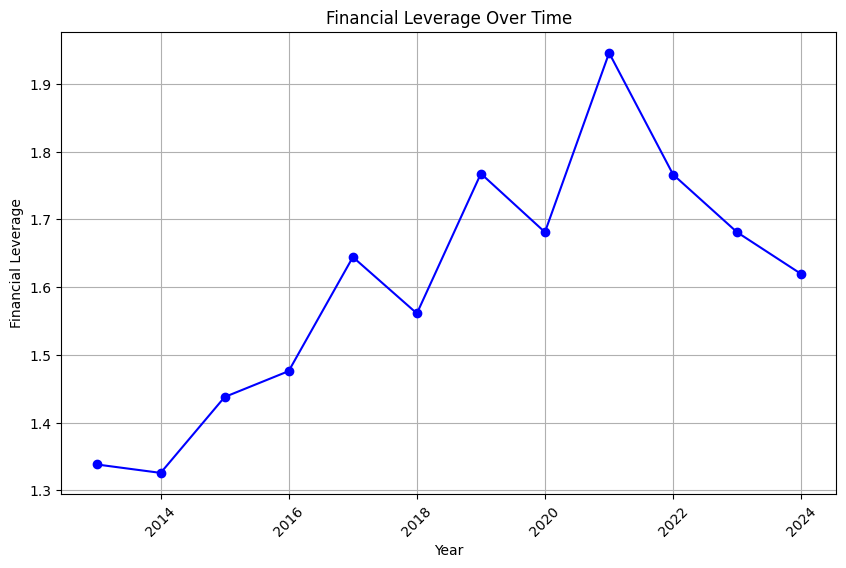

In [19]:
ratio_agent.chat("Plot financial leverage over time")